# Environmental Spatial Data Analysis

# Lecture 6

# Data Storage (Input/Output)

* This problem is one of the largest issues when you go to the TB-PB realm
* Tradeoff between ease of access and keeping storage costs low

So how do we solve this issue?

## Hardware: High perfomance computing (HPC)

Excuse #1: It doesn't matter how poorly I build my database, because I can just use bigger and better storage! 

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSF3ySEDjfFVCuSA-D9UHplpJ1oWWHlzFq0Ig&s" width="500">

## Hardware: Type of storage

Excuse #2: I'll just replace all my storage with faster storage!

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQSIPebMKodIt99SgqjeKSgVhhM2Fa0r-xK8A&s" width="500">



To be fair, the combination of HPC and SSD do make a large difference.

## Software: How we build databases

However, before we buy new hardware, we should optimize the software to reduce the size of our data and to make it very easy to access and manipulate.

And this will be our focus today.

Why? I don't want you to be wasting your time reinventing the wheel on file formats, when there are already very good solutions out there.

# Outline

* The hard way: Working with text files (e.g., CSV)
* The easy way: Pickle
* The best way: NetCDF/HDF5
* Other ways: (e.g., GeoTIFF)

# I/O: ASCII files (e.g., CSV)

Let's start by creating a csv file from our ERA-Interim data

In [ ]:
#Define the sites
sites = {'seattle':{'lat':47.6062,'lon':-122.3321},
         'paris':{'lat':48.8566,'lon':2.3522},
         'santiago':{'lat':-33.4489,'lon':-70.6693}}

In [ ]:
import netCDF4 as nc
#Open access to the file
file = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc'
fp = nc.Dataset(file)
lats = fp['lat'][:]
lons = fp['lon'][:]
times = fp['time']

In [ ]:
import numpy as np
#Look for the closest grid cell center for each site
for site in sites:
    lat = sites[site]['lat']
    lon = sites[site]['lon']
    if lon < 0:lon = 360 + lon
    sites[site]['ilat'] = int(np.argmin(np.abs(lats - lat)))
    sites[site]['ilon'] = int(np.argmin(np.abs(lons - lon)))
print(sites)

In [ ]:
import datetime
#Convert the dates/to a datetime array
dates = nc.num2date(times[:],units=times.units,calendar=times.calendar)

In [ ]:
#Read in multiple variables for each site
vars = {'t2m':'degC','precip':'mm/day','p_sfc':'hPa','wspd10':'m/s'}
for site in sites:
    for var in vars:
        ilat = sites[site]['ilat']
        ilon = sites[site]['ilon']
        sites[site][var] = fp[var][:,ilat,ilon]

In [ ]:
#Let's create a plot of all three sites
%matplotlib inline
import matplotlib.pyplot as plt
m = dates >= datetime.datetime(2015,1,1)
fig = plt.figure(figsize=(10,10))
for i in range(len(vars.keys())):
    plt.subplot(2,2,i+1)
    for site in sites:
        plt.title('%s (%s)' % (list(vars.keys())[i],vars[list(vars.keys())[i]]),fontsize=25)
        plt.plot(dates[m],sites[site][list(vars.keys())[i]][m],lw=5)
        plt.xticks(rotation=30,fontsize=20)
        plt.yticks(fontsize=20)
    if i == 0:
        plt.legend(list(sites.keys()),fontsize=15)
fig.tight_layout()
plt.show()

Let's now output the data. We are going to start with the hardest way (and yet the most common...).

In [ ]:
for site in sites:
    print(site)
    #Define the filename to write to
    file = '../Workspace/%s.txt' % site
    #Open the file in write mode
    fp = open(file,'w')
    #Let's add a header
    header = 'date,t2m,precip,p_sfc,wspd10'
    fp.write('%s\n' % header)
    #Now we will iterate through each time step and output the data
    for i in range(dates.size):
        #Convert the timestamp to a date string
        date = dates[i].strftime("%Y/%m")
        #Initialize a list called output with the date string as the first elemetn
        output = [date,]
        #Iterate through all the variables per time step and convert to a string
        #Then append to list
        for var in vars:
            output.append('%.3f' % sites[site][var][i])
        #Join all elements in the list to form one larger string
        string = ",".join(output)
        #Write the string out with an end of line (\n) at the end.
        fp.write('%s\n' % string)
    #Close the file
    fp.close()

Let's read all the data back in using the hardest way (again!)

In [ ]:
#Initialize the output dictionary
output = {}
for site in sites:
    print(site)
    if site not in output:output[site] = {'dates':[],'t2m':[],'precip':[],'p_sfc':[],'wspd10':[]}
    #Define the filename to write to
    file = '../Workspace/%s.txt' % site
    #Open the file in read mode
    fp = open(file,'r')
    #Now we will iterate through each line
    for line in fp:
        if 'date' in line:continue #Skip the header
        #Split the line
        tmp = line.split(',')
        #Place the data and convert if necessary
        output[site]['dates'].append(datetime.datetime.strptime(tmp[0],'%Y/%m')) #Convert back to datetime
        output[site]['t2m'].append(float(tmp[1]))
        output[site]['precip'].append(float(tmp[2]))
        output[site]['p_sfc'].append(float(tmp[3]))
        output[site]['wspd10'].append(float(tmp[4]))
    #Close the file
    fp.close()
    #Convert to arrays
    for var in output[site]:
        output[site][var] = np.array(output[site][var])

But are we getting the same result?

In [ ]:
i = 0
fig = plt.figure(figsize=(10,10))
for var in vars:
    for site in sites:
        i += 1
        plt.subplot(4,3,i)
        plt.title(site,fontsize=25)
        plt.plot(sites[site][var],output[site][var],'bo')
        plt.plot(sites[site][var],sites[site][var],'k')
        plt.ylabel('%s (%s)' % (var,vars[var]),fontsize=15)
        plt.xticks(rotation=30,fontsize=20)
        plt.yticks(fontsize=20)
fig.tight_layout()
plt.show()

It that really the best way to read and write spatial data in Python? 

**Definitely not**

Let's look at other options now

# ASCII vs Binary

<img src="http://web.alfredstate.edu/faculty/weimandn/miscellaneous/ascii/ASCII%20Conversion%20Chart.gif" width="500">

Reading/writing in ASCII is slower and takes up more space. The storage approaches we will use in this course (except for one of the problems in your homework) use binary.

# I/O: Pickle

Pickle is part of the Python Standard Library and is the **easiest** (but not always the best) method to read and write data in Python.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ0STI0v-pytnvZGNXPHw605HFsU9nS84rOOg&s" width="1000">

In [ ]:
import pickle
for site in sites:
    #Define filename
    file = '../Workspace/%s.pck' % site
    #Open the file as writable
    fp = open(file,'wb')
    #Create output database
    output = {'dates':dates,'data':sites[site]}
    pickle.dump(output,fp)
    #Close the file
    fp.close()

We can even make this easier

In [ ]:
#Define filename
file = '../Workspace/sites.pck'
#Open the file as writable
fp = open(file,'wb')
#Create output database
output = {'dates':dates,'data':sites}
pickle.dump(output,fp)
#Close the file
fp.close()

Then to read it back in, it is just as simple

In [ ]:
#Define filename
file = '../Workspace/sites.pck'
#Open the file as writable
fp = open(file,'rb')
#Create output database
output = {'dates':dates,'data':sites}
output = pickle.load(fp)
#Close the file
fp.close()

Same result?

In [ ]:
i = 0
fig = plt.figure(figsize=(10,10))
for var in vars:
    for site in sites:
        i += 1
        plt.subplot(4,3,i)
        plt.title(site,fontsize=25)
        plt.plot(sites[site][var],output['data'][site][var],'bo')
        plt.plot(sites[site][var],sites[site][var],'k')
        plt.ylabel('%s (%s)' % (var,vars[var]),fontsize=15)
        plt.xticks(rotation=30,fontsize=20)
        plt.yticks(fontsize=20)
fig.tight_layout()
plt.show()

Main point: Using Pickle is much easier than reading and writing text files. It is the go-to method when developing software that involves data in Python.

However, there are some important issues that limits using Pickle for everything

Main issues:

* The Pickle file format is exclusive to Python; this makes it difficult to share data with non-Python users
* Lack of partial I/O. The database must be written/read all at once. This can make the I/O process very slow and many times impossible due to computer memory limitations. This is especially a problem for ***Big Data*** (GB+) in environmental spatial data science.

What other alternatives could we use?


# Partial I/O

In [ ]:
%%bash
du -h /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc

In [ ]:
import netCDF4 as nc
#Open access to the file
file = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc'
fp = nc.Dataset(file)
print(fp.variables.keys())

Using ASCII or Pickle we would have to read in everything to be able to extract a single variable (e.g., t2m). Partial I/O only retrieves what you need. This speeds up things A LOT.

In [ ]:
data = fp['t2m'][0,:,:]
print(data.shape)
plt.imshow(np.flipud(data))

# I/O: netCDF4

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRvpVohjgr1gnFbGLi2lLtqz3yhCgT8PckelA&s" width="500">

<img src="https://archive.unidata.ucar.edu/software/netcdf/workshops/2012/architecture/images/netcdf_history_cropped.png" width="800">

What is **netCDF4**?

* Data model for scientific data 
    * Widely use in Earth and Environmental Sciences
    * And many other fields as well
* File format for portable data
    * Array-oriented data science
    * Self-describing, portable, and appendable
* Used in multiple programming languages
    * C, Java, Fortran, C++, Python, Matlab, IDL,...

<img src="https://archive.unidata.ucar.edu/software/netcdf/workshops/2011/datamodels/images/nc4-model.png" width="800">

Let's revisit our I/O example but now in netCDF4

In [ ]:
import netCDF4 as nc

In [ ]:
import os

#Define filename
file = '../Workspace/sites.nc'
os.system('rm -f %s' % file)

#Open the file as writable
fp = nc.Dataset(file,'w')

#Create dimensions
fp.createDimension('time',size=dates.size)

#Write the time data
fp.createVariable('t','i8',dimensions=('time',))
fp['t'].units = 'hours since 0001-01-01 00:00:00.0'
fp['t'].calendar = 'gregorian'
fp['t'][:] = nc.date2num(dates,units=fp['t'].units,calendar=fp['t'].calendar)
print(fp['t'][:])
#Create a group per site and then add data
for site in sites:
    fp.createGroup(site)
    #Iterate through all the variables and place data
    for var in vars:
        fpv = fp[site].createVariable(var,'f4',dimensions=('time',))
        fpv[:] = sites[site][var]
        
#Close the file
fp.close()

Let's go to the terminal to list the contents of this new NetCDF4 file.

In [ ]:
%%bash
ncdump -h ../Workspace/sites.nc

The command `ncdump -h` at the terminal does a quick query of a NetCDF4 file.

Let's now read the data back in to Python

In [ ]:
#Define filename
file = '../Workspace/sites.nc'

#Open the file as readable
fp = nc.Dataset(file,'r')

#Create a group per site and then add data
output = {}
for site in fp.groups:
    print(site)
    output[site] = {}
    #Iterate through all the variables and extract the data
    for var in fp[site].variables:
        output[site][var] = fp[site][var][:]
        
#Close the file
fp.close()

Let's check to see if it is the same thing...

In [ ]:
i = 0
fig = plt.figure(figsize=(10,10))
for var in vars:
    for site in sites:
        i += 1
        plt.subplot(4,3,i)
        plt.title(site,fontsize=25)
        plt.plot(sites[site][var],output[site][var],'bo')
        plt.plot(sites[site][var],sites[site][var],'k')
        plt.ylabel('%s (%s)' % (var,vars[var]),fontsize=15)
        plt.xticks(rotation=30,fontsize=20)
        plt.yticks(fontsize=20)
fig.tight_layout()
plt.show()

NetCDF4 example: Creating and placing the data

In [ ]:
data = np.zeros((10,200,200))
print(data.shape)
print(np.unique(data))

## Creating the netCDF file

In [ ]:
file = '../Workspace/test.nc'
os.system('rm -f %s' % file)
#Open the file as writable
fp = nc.Dataset(file,'w')

## Dimensions in a netCDF file

The netCDF format uses dimensions to define the shapes of variables. Before creating variables, we have to create dimensions.

In [ ]:
#Create dimensions
fp.createDimension('lat',size=data.shape[1])
fp.createDimension('lon',size=data.shape[2])
fp.createDimension('time',size=data.shape[0])

## Variables in a netCDF file

In [ ]:
#Add the data as a variable
fp.createVariable('data','f4',dimensions=('time','lat','lon'))
fp['data'][:] = data[:]

## Add some metadata

In [ ]:
fp['data'].units = 'units!'
fp['data'].missing_value = -9999

## Close up the file

In [ ]:
fp.close()

In [ ]:
%%bash
ncdump -h ../Workspace/test.nc
du -h ../Workspace/test.nc

## NetCDF compression: Reduce file size

In [ ]:
file = '../Workspace/test_compressed.nc'
os.system('rm -f %s' % file)
#Open the file as writable
fp = nc.Dataset(file,'w')
#Create dimensions
fp.createDimension('lat',size=data.shape[1])
fp.createDimension('lon',size=data.shape[2])
fp.createDimension('time',size=data.shape[0])
#Add the data as a variable
fp.createVariable('data','f4',dimensions=('time','lat','lon'),zlib=True,least_significant_digit=2)
fp['data'][:] = data[:,:,:]
fp['data'].units = 'units!'
fp['data'].missing_value = -9999
fp.close()

In [ ]:
%%bash
ncdump -h ../Workspace/test_compressed.nc
du -h ../Workspace/test_compressed.nc

We just took a file that was 1.6 MB and compressed it down to 16 KB. Any idea how? (Hint: it is not magic)

When we deal with datasets that consist of discrete values, have a lot of missing values, or have lots of 0s (e.g., precipitation), compression makes these data much easier to handle. 

## NetCDF files: CF convention

The CF convention is a set of common features that spatial data need to have in NetCDF (and other file formats) to ensure that the data can be shared with ease from one place to another.

It tells us how to name variables, what metadata we need to add, what dimensions are appropriate, etc...

http://cfconventions.org/Data/cf-documents/overview/viewgraphs.pdf

I am fully aware that the initial reaction is "who cares?". However, as you work with other data and create your own, using the CF convenction will avoid many, MANY emails to clarify a dataset.

## ERA-Interim: Example CF compliant

In [ ]:
%%bash 
ncdump -h /data/era-interim/era_interim_monthly_197901_201512_upscaled.nc

Want more specifics on what being CF compliant using NetCDF entails?

Go here: http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_netcdf_files_and_components

# I/O: HDF5

<img src="https://www.hdfgroup.org/wp-content/uploads/2017/06/benefits-wheel.png" width="500">

NetCDF4 is actually built on HDF5. Although we tend to use NetCDF4 for consistency, native HDF5 is faster and can be much more flexible. Unless I am aiming to share my data with the wider scientific community, I almost always only use native HDF5. 

<img src="https://image.slidesharecdn.com/rewnethdf-short-140220112557-phpapp01/95/plans-for-enhanced-netcdf4-interface-to-hdf5-data-6-638.jpg?cb=1392895997" width="600">


In [ ]:
import h5py
file = '../Workspace/sites.h5'

#Open the file as writable
fp = h5py.File(file,'w')

#Iterate per variable
for site in sites:
    fp.create_group(site)
    for var in vars:
        fp[site][var] = sites[site][var][:]
    
#Close the file
fp.close()

In [ ]:
%%bash

h5dump -n ../Workspace/sites.h5

Here we use `h5dump -n` at the terminal instead of `ncdump -h`. It is the exact same idea though.

Let's quickly prove that NetCDF4 is HDF5 by trying to read it as NetCDF4. 

In [ ]:
%%bash

ncdump -h ../Workspace/sites.h5

The main difference between NetCDF4 and HDF5 is that in NetCDF4 we have to specify dimensions while in HDF5 they are implicit unless we specify them. But yes, one can create a NetCDF4 file using h5py (or any HDF5 library). 

# I/O: Raster data

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Rgb-raster-image.svg/368px-Rgb-raster-image.svg.png" width="200">

Raster: A raster image is a data structure that represents a spatial grid of pixels. In other words, it's a 2D array. One tends to only think of rasters when thinking of 2D arrays with only lat and lon axes. N-dimensional arrays are a generalization of raster data. 

However, this word will emerge many times so better to not be confused!


## Raster data file formats

It seems that creating raster file formats used to be a hobby...

[Raster formats](https://gdal.org/drivers/raster/index.html)

Thankfully things have calmed down (kind of).

NetCDF and HDF5 are considered to be "raster formats". Although to be compliant they lose a lot of their flexibility. A lot of NASA satellite remote sensing data is in HDF-EOS (which can either be in HDF4 or HDF5).

## GeoTIFF: Most common raster format

In [ ]:
%%bash 
gdalinfo /data/NED/dem_lat3940_lon-93-92.tif

## Reading raster data in Python?

There are many options. We will use rasterio.

In [1]:
import rasterio
import matplotlib.pyplot as plt

In [2]:
file = '/data/NED/dem_lat3940_lon-93-92.tif'
#Open up access to the file
fp = rasterio.open(file)
#Read the first band (each time step would be a different band in a 3d array of time/lat/lon)
dem = fp.read(1)

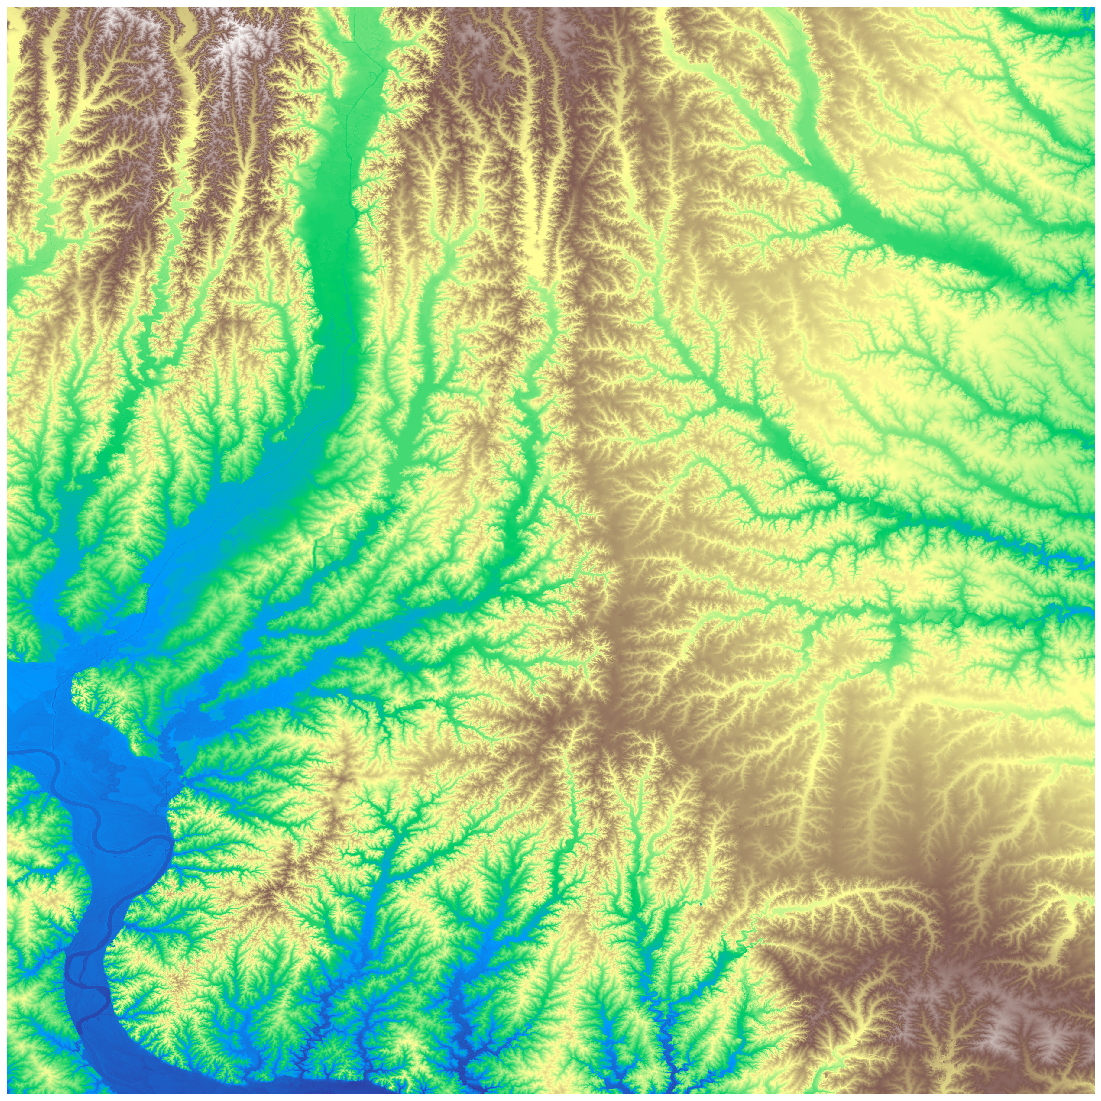

In [3]:
#Make a quick plot
plt.figure(figsize=(20,20))
plt.imshow(dem,cmap=plt.get_cmap('terrain'))
plt.axis('off')
plt.show()

If we look closer at the file pointer opened by Rasterio we can learn a lot about the data

In [ ]:
dir(fp)

We can directly determine the shape of the array (i.e., raster) before reading it in. 

In [4]:
print(fp.width)
print(fp.height)

3600
3600


We can extract the boundaries of the data. This example is in lat/lon.

In [5]:
print(fp.bounds)

BoundingBox(left=-93.0, bottom=38.99999999999992, right=-91.99999999999991, top=40.0)


It also tells us the map projection of the data

In [6]:
print(fp._crs)

EPSG:4326
